In [26]:
%load_ext autoreload
%autoreload 2

from juligrad.tensor import Tensor
from juligrad import nn, dataset, graph, optim, ops

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load some data

(60000, 1, 28, 28) (60000,)


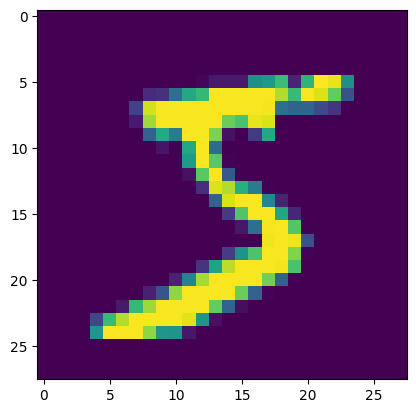

In [34]:
X, y = dataset.load_mnist(limit=None)
X_batches, y_batches  = dataset.splitBatches((X,y), batch_size=2048)
print(X.shape, y.shape)
plt.imshow(X.numpy()[0,0])

## Define the model and plot graph

[(5, 1, 5, 5), (5, 1), (2880, 10), (1, 10)]
Tensor(4664.867591649099) 0.0675


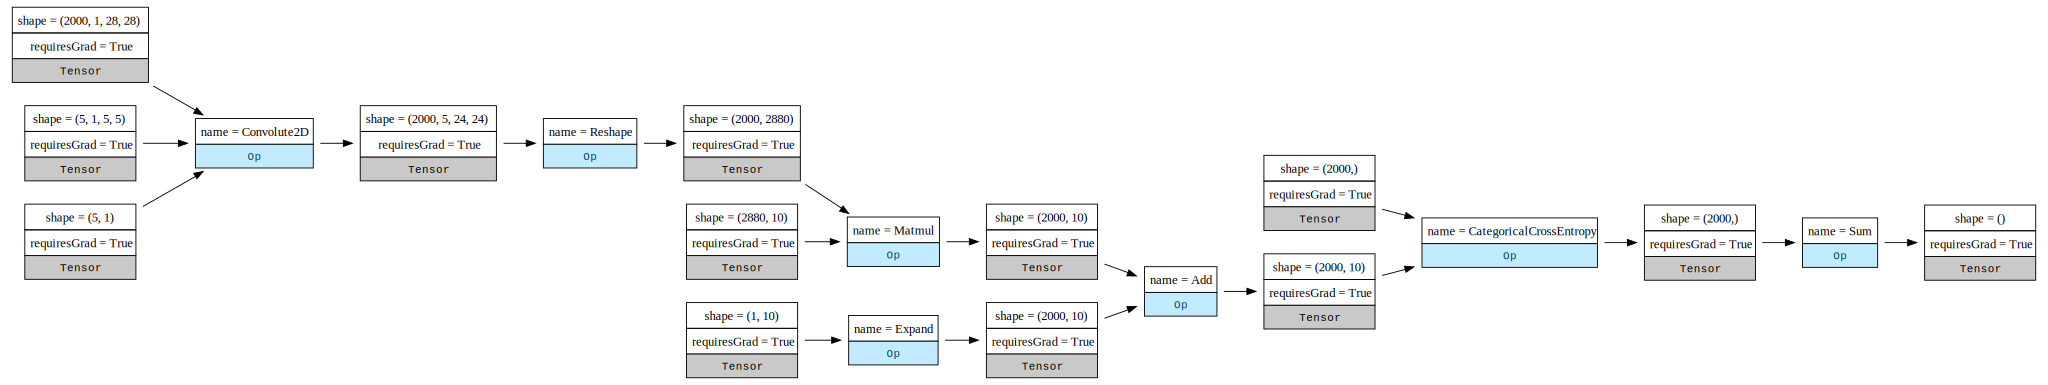

In [37]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(C=1, C_out=5, kernelSize=5, padding=0, stride=1)
        #self.conv2 = nn.Conv2d(C=5, C_out=10, kernelSize=3, padding=0, stride=1)

        self.linear = nn.Linear(shapeIn=2880, shapeOut= 10)

    def forward(self,X: Tensor) -> Tensor:
        out = self.conv1(X)
        #out = self.conv2(out)
        out = out.flatten()
        out = self.linear(out)
        #out = out.softmax(axis=-1)
        return out

def accuracy(pred:Tensor, y:Tensor) -> float:
    return np.mean(np.argmax(pred.data, axis=1) == y.data)

#Test forward and backward pass
mod = ConvNet()
print([param.shape for param in mod.parameters()])
pred = mod(X_batches[0])
ce = ops.CategoricalCrossEntropy()
loss = ce(pred, y_batches[0]).sum()
acc = accuracy(pred,y_batches[0])
print(loss, acc)
loss.backward()
#print(loss.grad)
#print(pred.grad)
graph.generateGraph(loss)

## Train 

30it [00:35,  1.17s/it, loss=2163.054]
30it [00:41,  1.40s/it, loss=1485.026]
30it [00:39,  1.32s/it, loss=1198.145]
30it [00:30,  1.01s/it, loss=1039.89] 
30it [00:30,  1.01s/it, loss=939.24]  
30it [00:30,  1.03s/it, loss=869.368] 
30it [00:29,  1.00it/s, loss=817.903] 
30it [00:30,  1.00s/it, loss=778.344] 
30it [00:30,  1.00s/it, loss=746.943] 
30it [00:30,  1.01s/it, loss=721.386] 
30it [00:31,  1.04s/it, loss=700.164] 
30it [00:30,  1.02s/it, loss=682.25]  
30it [00:30,  1.00s/it, loss=666.921] 
30it [00:30,  1.02s/it, loss=653.651] 
30it [00:35,  1.18s/it, loss=642.05] 
30it [00:39,  1.32s/it, loss=631.821] 
30it [00:39,  1.32s/it, loss=622.734] 
30it [00:35,  1.18s/it, loss=614.608]
30it [00:35,  1.19s/it, loss=607.3]   
30it [00:39,  1.30s/it, loss=600.692] 


Accuracy: 0.8888833333333334


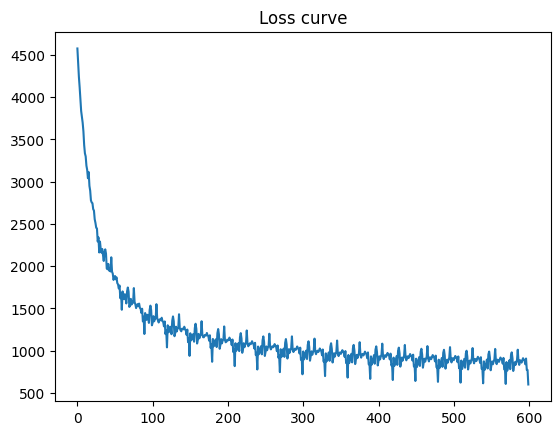

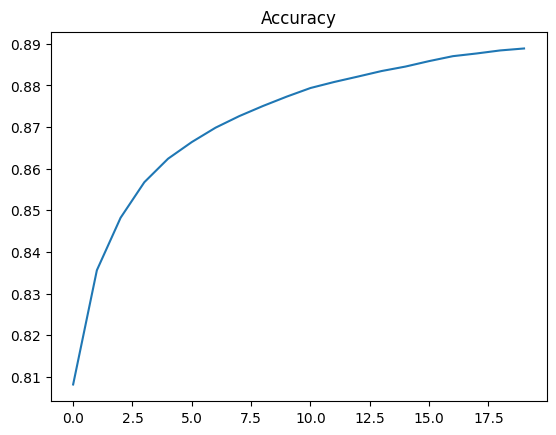

In [38]:
mod = ConvNet()
optimizer = optim.SGD(params=mod.parameters(), lr=1e-4)
nEpoch, lossHist, accHist =20, [], []
for i in range(nEpoch):
    for X_batch, y_batch in (pbar := tqdm(zip(X_batches, y_batches))):
        optimizer.zeroGrad()
        pred = mod(X_batch)
        loss = ce(pred,y_batch).sum()
        lossHist.append(loss.numpy()); pbar.set_postfix({'loss': f"{loss.numpy().round(3)}"})
        loss.backward()
        optimizer.step()
    accHist.append(accuracy(mod(X),y))

plt.plot(lossHist);plt.title('Loss curve');
plt.figure(); plt.plot(accHist);plt.title('Accuracy');
print(f"Accuracy: {accHist[-1]}")

## Evaluate

In [39]:
X_test, y_test = dataset.load_mnist(set=dataset.MNIST.test)
test_pred = mod(X_test)
test_acc = accuracy(test_pred,y_test)
print(f"Test accuracy: {test_acc}")

Test accuracy: 0.895
